# Result analysis

In [130]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import json
import baseline
import numpy as np
from baseline import *
from decoder import *
from alphabet import *
from train import *
import torch
from matplotlib import pyplot as plt
import collections

torch.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.4.0'

### Dataset and language setup

In [ ]:
LANGUAGE = "Python"

def filter_ascii(strings):
    'Returns only the strings that can be encoded in ASCII.'
    l = []
    for s in strings:
        try:
            s.encode('ascii')
            if 10 <= len(s) <= 80:
                l.append(s)
        except UnicodeEncodeError:
            pass
        
    return list(set(l))

def language_2_dataset(language='Python'):
    with open('dataset/large.json') as f:
        multilang_dataset = json.load(f)
        dataset = multilang_dataset[language]

        dataset['train'] = filter_ascii(dataset['train'])
        dataset['dev'] = filter_ascii(dataset['dev'])
        dataset['test'] = filter_ascii(dataset['test'])
        print('{} training examples, {} validation examples, {} test exampless'.format(
            len(dataset['train']), 
            len(dataset['dev']),
            len(dataset['test'])))
        return dataset
    
full_dataset = {
    "python": language_2_dataset("Python"),
    "haskell": language_2_dataset("Haskell"),
    "java": language_2_dataset("Java"),
}

602762 training examples, 80964 validation examples, 80789 test exampless


## Models we ran

In [113]:
python_dat = full_dataset["python"]
java_dat = full_dataset["java"]
haskell_dat = full_dataset["haskell"]

models = [
    (UniformEncoder(removal_probability=.8),.0005, python_dat, 'python'), 
    (RulesBasedEncoder(), .0001, python_dat, 'python'),
    (UniformEncoder(removal_probability=.9) , .0001, python_dat, 'python'), 
    (FrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python'), 
    (FrequencyEncoder(dataset=python_dat['train'], compression_rate=.9, n_gram=5), .0005, python_dat, 'python'), 
    
    (FrequencyEncoderConstantDrop(dataset=python_dat['train'], num_chars=5, n_gram=5), .0005, python_dat, 'python'),
    (FrequencyEncoderConstantDrop(java_dat['train'], num_chars=5, n_gram=5), .0005, java_dat, 'java'),
    (FrequencyEncoderConstantDrop(haskell_dat['train'], num_chars=5, n_gram=5), .0005, haskell_dat, 'haskell'),
    (UniformEncoderConstantDrop(num_chars=5), .0005, python_dat, 'python'),
    (UniformEncoderConstantDrop(num_chars=5), .0005, java_dat, 'java'),
    (UniformEncoderConstantDrop(num_chars=5), .0005, haskell_dat, 'haskell'),
]

In [114]:
def load_model(model, is_baseline=True, load_best=False):
    device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
    encoder, alpha, dataset, lang_name = model

    if load_best:
        # Load the best model saved during training.
        filename = "trained_models/{}_best_".format(encoder.name())
        loss_history_filename = "trained_models/best_model_{}".format(encoder.name())
    else:
        # Load the final model.
        filename = "trained_models/{}_{}_{}".format(encoder.name(), alpha, lang_name)
        loss_history_filename = "trained_models/{}_{}_{}.json".format(encoder.name(), alpha, lang_name)

    alphabet = AsciiEmbeddedEncoding(device)
    decoder = AutoCompleteDecoderModel(alphabet, hidden_size=512, copy=None)    
    decoder.load_state_dict(torch.load(filename + "decoder.model"))
    alphabet.load_state_dict(torch.load(filename + "alphabet.model"))
    
    decoder.to(device)
    alphabet.to(device)
    
    if not is_baseline:
        encoder.load_state_dict(torch.load(filename + "encoder.model"))

    with open(loss_history_filename) as f:
        j = json.load(f)
        loss_history = j["losses"]
        
    return (encoder, decoder, alphabet, lang_name, loss_history)

loaded_models = []

for m in models:
    try:
        loaded_models.append(load_model(m))
        print('Model', m[0].name(), 'loaded!')
    except Exception as e:
        pass
        
print(len(loaded_models), 'model(s) loaded.')

Model UniformEncoder(0.80) loaded!
Model FrequencyEncoder(5-gram, target_size:0.9) loaded!
Model FrequencyEncoderConstantDrop(5-gram, drop:5) loaded!
Model FrequencyEncoderConstantDrop(5-gram, drop:5) loaded!
Model UniformEncoderConstantDrop(5.00) loaded!
5 model(s) loaded.


# Plot loss history

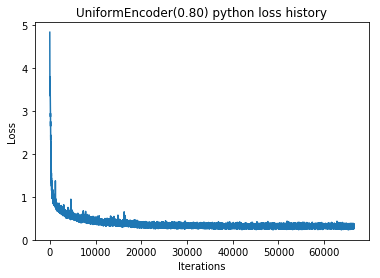

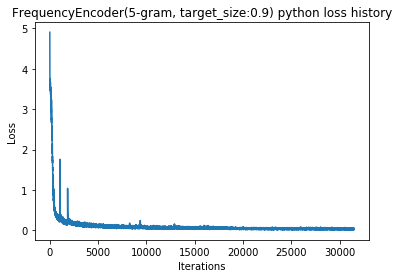

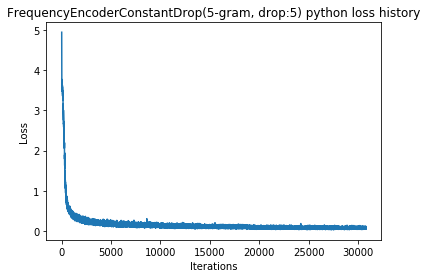

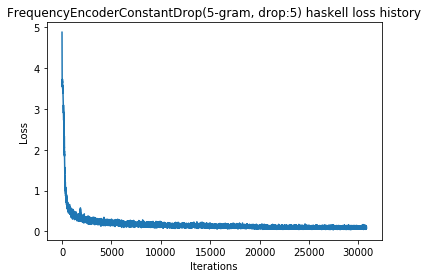

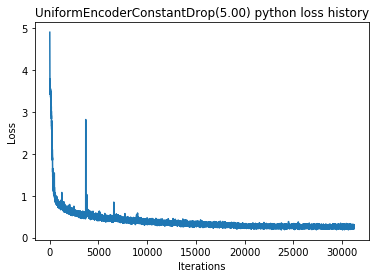

In [115]:
for (encoder, decoder, alphabet, lang, loss_history) in loaded_models:
    plt.title('{} {} loss history'.format(encoder.name(), lang))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(loss_history)
    plt.show()


# Metrics

In [127]:
BATCH_SIZE = 128

def reset_seeds():
    # Set seed before computing accuracy to make the encoders deterministic.
    np.random.seed(224)
    random.seed(224)
    torch.manual_seed(224)

# TOOD: move these to a file
def edit_distance(s1,s2):
    if len(s1)==0: return len(s2)
    if len(s2)==0: return len(s1)
    if s1[0] == s2[0]: return edit_distance(s1[1:], s2[1:])
    return 1 + min(edit_distance(s1[1:],s2),
                   edit_distance(s1,s2[1:]),
                   edit_distance(s1[1:],s2[1:]))

def batched_decode_all(model, dataset):
    reset_seeds()

    (encoder, decoder, alphabet, _, _) = model
    
    encoded_strings = [encoder.encode(s) for s in dataset]
    decoded = []    

    for i in range((len(dataset) + BATCH_SIZE - 1) // BATCH_SIZE):
        decoded.extend(decoder(encoded_strings[i*BATCH_SIZE:(i+1)*BATCH_SIZE], alphabet))

    return list(zip(dataset, encoded_strings, decoded))
    
def top1accuracy(examples, dataset):
    return sum([examples[i][0] == examples[i][2] for i in range(len(dataset))]) / len(dataset)

def top5accuracy(model, dataset, max_length=100):
    (encoder, decoder, alphabet, _, _) = model
    count = 0
    for string in dataset:
        compressed = encoder.encode(string)
        best_five = list(map(lambda x:x[1][1:-1], 
                             decoder.beam_search(compressed, alphabet, beam_size=5, max_depth=max_length)))
        if string in best_five: count += 1
    return float(count) / len(dataset)

def editAccuracy(dataset):
    return average([
        edit_distance(decoder(encoder.encode(s), alphabet), 
                      s)/len(s) for s in dataset])

# Run evaluation

The functions below are filters to compute metrics in diffetent slices of the dataset

In [120]:
def all_lines(original, encoded):
    return True

def short_lines(original, encoded):
    return len(original) <= 25

def long_lines(original, encoded):
    return len(original) >= 65

all_slices = {
    'all_lines': all_lines,
    'short_lines': short_lines,
    'long_lines': long_lines,
}

In [129]:
def evaluate(model, split, pred_filter=id):
    (encoder, decoder, alphabet, language, _) = model
    dataset = full_dataset[language][split][:2000]
    
    examples = batched_decode_all(model, dataset)
    examples = [(o, e, d) for (o, e, d) in examples if pred_filter(o, e)]
    
    compression = sum(len(enc) for orig, enc, dec in examples) / sum(len(s) for s in dataset)
    top1_acc = top1accuracy(examples, dataset)
    return top1_acc, compression

for model in loaded_models:
    print('Testing', model[0].name(), model[3])

    for split in ['test']:
        for slice_name, predicate in all_slices.items():
            top1_acc, compression = evaluate(model, split, predicate)
            print(' ' * 8, split, slice_name, 'top-1 accuracy:', top1_acc, 'compression rate: {:.3f}'.format(compression))

Testing UniformEncoder(0.80) python
         test all_lines top-1 accuracy: 0.1855 compression rate: 0.800


IndexError: list index out of range